In [1]:
import os 
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from loguru import logger

from models.cluster import KMeansClusterModel
from models.cluster import DBSCANClusterModel
from models.cluster import HierarchicalCluster

from utils.load import load_sequences, load_metadata
from utils.pitch import extract_pitch_based_features
from utils.pitch import plot_pca_variance
from utils.pitch import plot_clusters, plot_dendrogram

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# functions

In [3]:
def extract_all_features(max_interval=12):
    """Extract pitch-based features from all sequences and return a dataframe."""
    records = []
    sequences_df = load_sequences("data/sequences")

    for idx, row in sequences_df.iterrows():
        seq = row["sequence"]
        features = extract_pitch_based_features(seq, max_interval=max_interval)

        if np.any(np.isnan(features)):
            continue  # skip bad sequences

        records.append({
            "id": idx,
            "features": np.array(features, dtype=float),
            "path": row["path"]
        })

    df = pd.DataFrame(records, index=[r["id"] for r in records]).sort_index()
    return df


def apply_pca(features_df, keep_variance=0.95):
    """Scale features and apply PCA."""
    X = np.vstack(features_df["features"].values)

    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    pca = PCA(n_components=keep_variance, random_state=42)
    X_pca = pca.fit_transform(X_std)

    if X_pca.shape[1] == 57:
        logger.info(
            f"PCA reduced from {X.shape[1]} → {X_pca.shape[1]} dims "
            f"({pca.explained_variance_ratio_.sum():.2%} variance kept)"
        )

        #plot_pca_variance(pca)
    return X_pca, pca, scaler


In [4]:
def run_clustering(
    method: str = "kmeans",
    features_df=None,
    X_pca=None,
    n_clusters: int = 4,
    **kwargs
):
    """
    Run a single clustering method on precomputed PCA features.
    """
    if features_df is None or X_pca is None:
        raise ValueError("features_df and X_pca must be provided.")

    method_lower = method.lower()

    # ----------------------------
    # Select clustering model
    # ----------------------------
    if method_lower == "kmeans":
        model = KMeansClusterModel(
            n_clusters=n_clusters,
            max_iters=kwargs.get("max_iters", 300),
            random_state=kwargs.get("random_state", 42),
        )

    elif method_lower == "dbscan":
        model = DBSCANClusterModel(
            eps=kwargs.get("eps", 8),
            min_samples=kwargs.get("min_samples", 4),
        )

    elif method_lower == "hierarchical":
        model = HierarchicalCluster(
            method=kwargs.get("linkage", "agglomerative"),
            n_clusters=n_clusters
        )

    else:
        raise ValueError(f"Unknown clustering method: {method}")

    model.fit(X_pca)
    labels = model.labels_
    features_df["cluster"] = labels

    logger.info(f"{method.upper()} cluster distribution:")
    logger.info(features_df["cluster"].value_counts())

    return {
        "features_df": features_df,
        "model": model,
        "X_pca": X_pca
    }


# comparing all clustering methods

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def compare_clustering_methods(
    features_df,
    X_pca,
    methods_params=None,
    plot=True
):
    """
    Compare multiple clustering methods on the same PCA-transformed features.
    """
    if methods_params is None:
        methods_params = {
            "kmeans": {"n_clusters": 4},
            "dbscan": {"eps": 7, "min_samples": 4},
            "hierarchical_agg": {"n_clusters": 4, "linkage": "agglomerative"},
            "hierarchical_div": {"n_clusters": 4, "linkage": "divisive"},
        }

    results = []

    for method_name, params in methods_params.items():
        print(f"\nRunning {method_name}...")

        if method_name.startswith("hierarchical"):
            res = run_clustering(
                method="hierarchical",
                features_df=features_df.copy(),
                X_pca=X_pca,
                **params
            )
        else:
            res = run_clustering(
                method=method_name,
                features_df=features_df.copy(),
                X_pca=X_pca,
                **params
            )

        labels = res["features_df"]["cluster"].values
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # exclude noise

        if n_clusters > 1:
            sil = silhouette_score(X_pca, labels)
            db = davies_bouldin_score(X_pca, labels)
            ch = calinski_harabasz_score(X_pca, labels)
        else:
            sil, db, ch = np.nan, np.nan, np.nan

        results.append({
            "method": method_name,
            "n_clusters": n_clusters,
            "silhouette": sil,
            "davies_bouldin": db,
            "calinski_harabasz": ch
        })

        if plot:
            plot_clusters(
                X_pca, labels,
                dim=3,
                title=f"{method_name.upper()} Clusters"
            )

    comparison_df = pd.DataFrame(results).sort_values(by="silhouette", ascending=False)
    return comparison_df

2025-11-24 14:44:22.698 | INFO     | utils.load:load_sequences:59 - Loading sequences from data/sequences with extension .npy
Loading sequences: 91it [00:00, 5757.93it/s]
2025-11-24 14:44:22.717 | SUCCESS  | utils.load:load_sequences:81 - Loaded 91 sequences from data/sequences
2025-11-24 14:44:22.833 | INFO     | __main__:apply_pca:34 - PCA reduced from 169 → 57 dims (95.23% variance kept)
2025-11-24 14:44:22.834 | INFO     | __main__:run_clustering:45 - KMEANS cluster distribution:
2025-11-24 14:44:22.835 | INFO     | __main__:run_clustering:46 - cluster
0    45
2    41
1     2
3     1
Name: count, dtype: int64



Running kmeans...


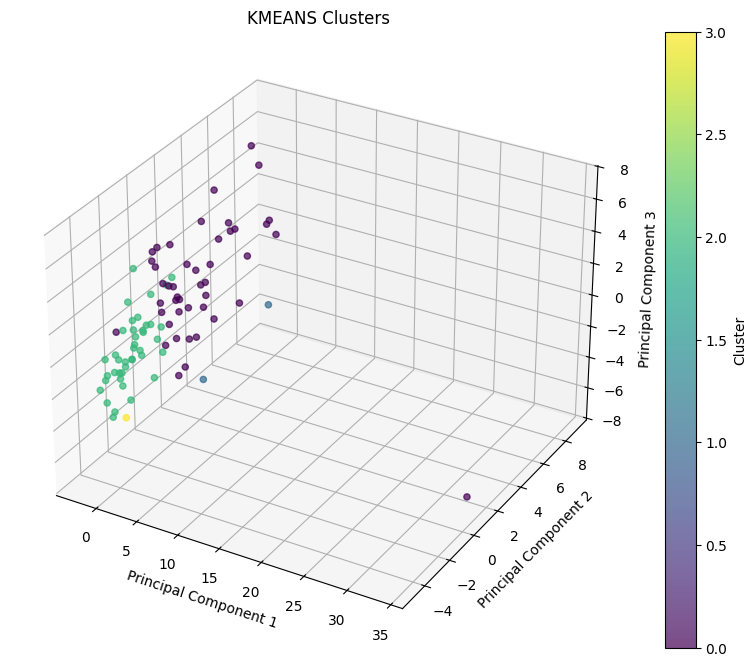

2025-11-24 14:44:22.892 | INFO     | __main__:run_clustering:45 - DBSCAN cluster distribution:
2025-11-24 14:44:22.893 | INFO     | __main__:run_clustering:46 - cluster
-1    78
 0    11
Name: count, dtype: int64



Running dbscan...


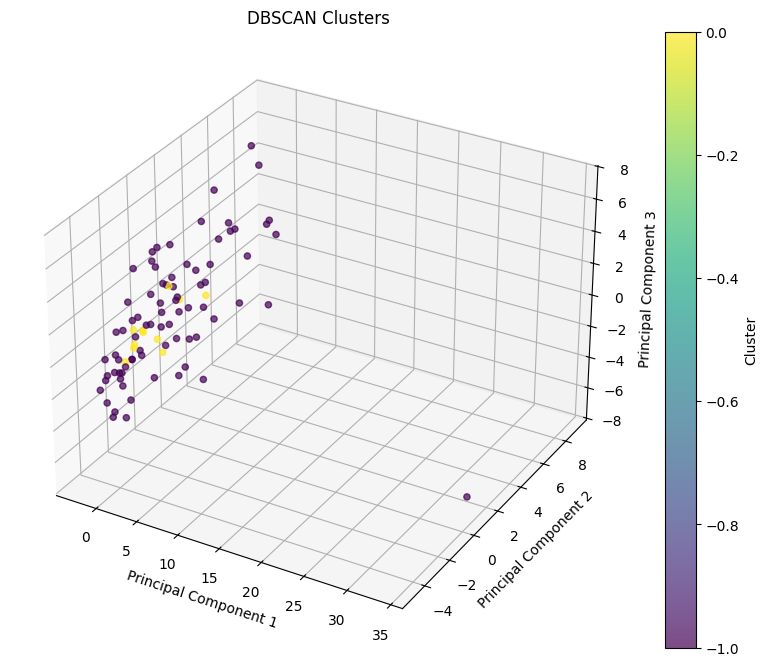


Running hierarchical_agg...


2025-11-24 14:44:23.750 | INFO     | __main__:run_clustering:45 - HIERARCHICAL cluster distribution:
2025-11-24 14:44:23.750 | INFO     | __main__:run_clustering:46 - cluster
3    86
0     1
1     1
2     1
Name: count, dtype: int64


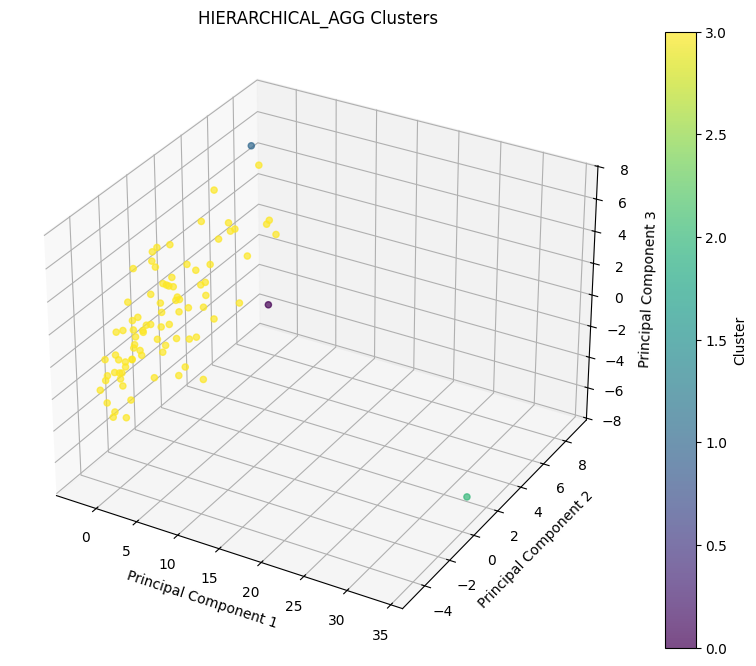

2025-11-24 14:44:23.913 | INFO     | __main__:run_clustering:45 - HIERARCHICAL cluster distribution:
2025-11-24 14:44:23.913 | INFO     | __main__:run_clustering:46 - cluster
3    53
1    31
2     4
0     1
Name: count, dtype: int64



Running hierarchical_div...


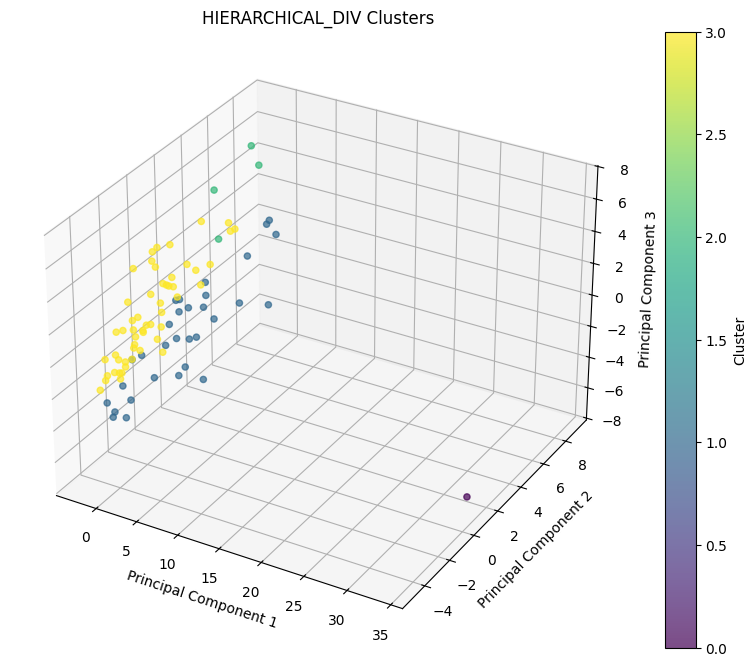

             method  n_clusters  silhouette  davies_bouldin  calinski_harabasz
2  hierarchical_agg           4    0.265190        0.510712           4.651454
3  hierarchical_div           4    0.053953        2.646669           5.190587
0            kmeans           4    0.017216        2.684687           2.856266
1            dbscan           1         NaN             NaN                NaN


In [19]:
features_df = extract_all_features(max_interval=12)
X_pca, _, _ = apply_pca(features_df, keep_variance=0.95)

comparison_table = compare_clustering_methods(
    features_df=features_df,
    X_pca=X_pca,
    plot=True
)

print(comparison_table)
